### This notebook is for research on the MIND paper from Tank lab-
- paper: https://www.biorxiv.org/content/10.1101/418939v2.full.pdf

### Goals 
1. Run some simulations from the MIND paper to replicate Figure 1
    - use the [RatInABox](https://github.com/TomGeorge1234/RatInABox) software to assist with simulations (at least for an agent trajectory, maybe more). Currently the RatInABox repository is located here: C:\Users\andrew\Documents\gitRepositories\RatInABox
2. Once I have a working model, try installing multiple environments in the same network of neurons, with the remapping performed in a few different ways. The different ways are listed below in the section "ideas to test". 

### Perspective
There is an open question in hippocampal neuroscience (I think...) about how spatial coding and recoding occurs. In particular, it is not known whether remapping is random and orthogonal, or constrained by intrinsic hippocampal architecture. I think it could be interesting and fruitful to combine a model of latent space (e.g., MIND) with simulated activity patterns based on experimentally-predicted assumptions about remapping and hippocampal architecture to learn how each assumptions affects the global manifold and each local manifold. 

### Ideas to Test
1. Losonczy lab - Geiller et al., 2021 - specific connection patterns between place cells and local inhibitory neurons
2. Spruston lab - The MEC/LEC anatomy - constrained inputs from MEC/LEC that are better than usual at driving plateau potentials


In [55]:
%load_ext autoreload
%autoreload 2

# Inclusions
import sys, os
sys.path.append(os.path.join('C:/', 'Users','andrew','Documents','gitRepositories','RatInABox'))

import time
import numpy as np
import scipy
import matplotlib.pyplot as plt
import ratinabox
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
import mindAlgorithm1 as mind

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
# box coordinates
def getBoxCoord(boxLength):
    xpos,ypos = np.meshgrid(np.arange(0,boxLength),np.arange(0,boxLength))
    return xpos,ypos

# random centroid selection (so can easily switch between random modes...)
def randCentroid(boxLength):
    xc = np.random.randint(0,boxLength) #np.random.random() * boxLength
    yc = np.random.randint(0,boxLength) #np.random.random() * boxLength
    return xc,yc

# return gaussian variance given a desired FWHM
def fwhmVar(x):
    return x**2 / (8*np.log(2))

# create place map given a centroid, place width, and room coordinates
def getPlaceMap(xcenter,ycenter,xpos,ypos,placeWidth):
    placeVar = fwhmVar(placeWidth)
    numerator = -(xpos - xcenter)**2 -(ypos-ycenter)**2
    denominator = 2*placeVar
    return np.exp(numerator / denominator)

# generate grid cell firing pattern (using Monaco & Abbott, 2011)
def getGridMap(xcenter,ycenter,xpos,ypos,gridSpacing,gridAngle):
    theta = np.array([-np.pi/3, 0, np.pi/3])
    u = lambda theta : np.array([np.cos(theta), np.sin(theta)])
    spOffsets = np.stack((xpos-xcenter, ypos-ycenter),axis=2)
    scaleFactor = (4*np.pi)/(np.sqrt(3)*gridSpacing)
    cosArgument = np.array([np.cos(scaleFactor*np.sum(spOffsets*u(theta[i]-gridAngle),axis=2)) for i in range(len(theta))])
    return np.sum(cosArgument,axis=0)

In [146]:
# used for debugging!!!

# inclusions
import numpy as np
import scipy

# function library
def constructForest(currentData, successorData, nEnsemble=5, nDir=2, nLeaf=40, nQuant=10):
    randomForest = {}
    randomForest['nEnsemble'] = nEnsemble
    randomForest['nDir'] = nDir
    randomForest['nLeaf'] = nLeaf
    randomForest['nQuant'] = nQuant
    randomForest['tree'] = []
    for _ in range(nEnsemble):
        randomForest['tree'].append(splitForestNode(currentData,successorData,ppcaModel={},nDir=nDir,nLeaf=nLeaf,nQuant=nQuant))
    return randomForest


def splitForestNode(currentData, successorData, ppcaModel={}, nDir=2, nLeaf=40, nQuant=10):
    # split a node in the dataset
    # Nodes are defined as:
    # - an ndarray of currentData and successorData (same shape and aligned)
    # - a dictionary with the PPCA model for the current & successor data
    # - ---- - if the dictionary is empty, assume it's the root node. if it is also a terminal node (by nLeaf), then generate an error!
    # Return node dictionary
    
    # Define node dictionary to be returned
    node = {}
    
    # if ppcaModel is empty, then this is the root node
    rootNode = (ppcaModel=={})
    
    # important variables for function
    N,D = currentData.shape # N=number of neurons, D=number of datapoints (in this node)
    
    # If this can't be split according to parameters, then return node!
    if D < 2*nLeaf:
        # If it has too few points to be split, and no PPCA model is provided, this function assumes it's a root node. But these are incompatible!
        if rootNode:
            raise ValueError("Too few data points to split, but no PPCA model provided (it is a terminal and a root node)")
        # If it has too few points to be split, but has a PPCA model, then it is a terminal node. Return PPCA model, identify it as a terminal node, and stop.
        if not checkValidPPCA(ppcaModel):
            raise ValueError("Terminal node identified, but no PPCA model provided")
        node['terminalNode'] = True
        node['mean'] = ppcaModel['mean']
        node['covariance'] = ppcaModel['covariance']
        node['likelihood'] = ppcaModel['likelihood']
        return node
    
    # If this node is being split, find the best split direction
    node['terminalNode'] = False
    hyperplane, leftNode, rightNode, leftData, leftSuccessor, rightData, rightSuccessor = optimizeHyperplane(currentData, successorData, nDir, nLeaf, nQuant)
    
    # Add hyperplane to node dictionary
    node['hyperplane'] = hyperplane
    
    # Return left and right leaves of node (recursively create tree, this function will call itself until it returns a terminal node)
    node['left'] = splitForestNode(leftData, leftSuccessor, ppcaModel=leftNode, nDir=nDir, nLeaf=nLeaf, nQuant=nQuant)
    node['right'] = splitForestNode(rightData, rightSuccessor, ppcaModel=rightNode, nDir=nDir, nLeaf=nLeaf, nQuant=nQuant)
    return node

def optimizeHyperplane(currentData, successorData, nDir=2, nLeaf=40, nQuant=10):
    # choosing a hyperplane to create a decision boundary
    # we aim to model the successor states of our left and right leaf nodes with a multivariate gaussian.
    # outputs hyperplane separating data (as a dictionary) and left/right current and successor data
    
    if currentData.ndim != 2 or successorData.ndim != 2:
        raise ValueError("data must be a matrix")
    
    if currentData.shape != successorData.shape:
        raise ValueError("current data and successor data must have same shape")
    
    # important variables for function
    N,D = currentData.shape # N=number of neurons, D=number of datapoints (in this node)
    
    # Confirm that this data can be split (shouldn't even make it here if it can't, but always good to check!)
    if D < 2*nLeaf:
        raise ValueError("optimizeHyperplane received data with too few datapoints to split!!")
    
    # Prepare splitting procedure (use quantile speedup trick for decision thresholds)
    numDatapointsPerQuant = D/nQuant
    quantOffset = int(np.ceil(nLeaf / (D/nQuant)))
    quantPoints = np.linspace(0,1,nQuant+1)[quantOffset:-quantOffset]
    if len(quantPoints)==0:
        # If there are two few points, just slice the data in half
        quantPoints = 0.5
    elif quantOffset>1:
        # If the offset is greater than 1, still query nQuant points! 
        quantPoints = np.linspace(quantPoints[0],quantPoints[-1],nQuant) 

    # Generate candidate hyperplane directions on unit hypersphere
    hypDirs = np.zeros((N,nDir)) # do it this way to avoid annoyance, it's very much not the bottleneck of the pipeline 
    while np.any(np.sum(hypDirs,axis=0) == 0): hypDirs = np.random.normal(0,1,(N,nDir))
    hypDirs = hypDirs / np.sqrt(np.sum(hypDirs**2,axis=0))
    
    # Preallocate variables
    hypThresholds = np.zeros(nDir)
    llCandidate = np.zeros((nDir,2))
    uCandidate = np.zeros((nDir,N,2))
    covCandidate = np.zeros((nDir,N,N,2))
    for ndir in range(nDir):
        cProjection = currentData.T @ hypDirs[:,ndir]
        cQuantiles = np.quantile(cProjection, quantPoints)
        ssError = []
        for cThreshold in cQuantiles:
            # Do isotropic gaussian model first
            idxLeft = np.where(cProjection <= cThreshold)[0]
            idxRight = np.where(cProjection > cThreshold)[0]
            cMeanLeft = np.mean(successorData[:,idxLeft],axis=1,keepdims=True)
            cMeanRight = np.mean(successorData[:,idxRight],axis=1,keepdims=True)
            cDevLeft = np.sum((successorData[:,idxLeft] - cMeanLeft)**2)
            cDevRight = np.sum((successorData[:,idxRight] - cMeanRight)**2)
            ssError.append(cDevLeft+cDevRight)
        
        # Then, for the best isotropic fit, compute a full ppca model
        idxBestThreshold = np.argmin(ssError)
        idxLeft = np.where(cProjection <= cQuantiles[idxBestThreshold])[0]
        idxRight = np.where(cProjection > cQuantiles[idxBestThreshold])[0]
        
        hypThresholds[ndir] = cQuantiles[idxBestThreshold]
        llCandidate[ndir,0],uCandidate[ndir,:,0],covCandidate[ndir,:,:,0] = ppca(successorData[:,idxLeft].T)[0:3]
        llCandidate[ndir,1],uCandidate[ndir,:,1],covCandidate[ndir,:,:,1] = ppca(successorData[:,idxRight].T)[0:3]
    
    # Find optimal direction, return indices for left and right data
    totalLikelihood = np.sum(llCandidate,axis=1)
    idxHyperplane = np.argmax(totalLikelihood)
    bestProjection = currentData.T @ hypDirs[:,idxHyperplane]
    idxLeft = np.where(bestProjection <= cThreshold)[0]
    idxRight = np.where(bestProjection > cThreshold)[0]
    
    # Save optimal hyperplane to dictionary
    hyperplane = {}
    hyperplane['direction'] = hypDirs[:,idxHyperplane]
    hyperplane['threshold'] = hypThresholds[idxHyperplane]
    # Save left node parameters to dictionary
    leftNode = {}
    leftNode['mean'] = uCandidate[idxHyperplane,:,0]
    leftNode['covariance'] = covCandidate[idxHyperplane,:,:,0]
    leftNode['likelihood'] = llCandidate[idxHyperplane,0]
    # Save right node parameters to dictionary
    rightNode = {}
    rightNode['mean'] = uCandidate[idxHyperplane,:,1]
    rightNode['covariance'] = covCandidate[idxHyperplane,:,:,1]
    rightNode['likelihood'] = llCandidate[idxHyperplane,1]
    
    return hyperplane, leftNode, rightNode, currentData[:,idxLeft], successorData[:,idxLeft], currentData[:,idxRight], successorData[:,idxRight]

def ppca(data, minVariance=0.95):
    # probabilistic ppca - using description in Methods Section 1.7 of the following: https://www.biorxiv.org/content/10.1101/418939v2.full.pdf
    # data is a (observations x dimensions) array 
    # minVariance defines minimum fraction of variance required for fitting the PPCA model
    
    if data.ndim != 2:
        raise ValueError("data must be a matrix")
    
    # Return ML estimate of mean
    uML = np.mean(data,axis=0)
    cdata = data - uML # use centered data for computations
    
    # Pick method based on computational speed (logic inherited from Low/Lewallen, haven't tested yet!)
    N,D = data.shape
    if N > D:
        # do eigendecomposition
        covData = np.cov(cdata.T, bias=True)
        w,v = scipy.linalg.eigh(covData)
        w[w<=np.finfo(float).eps]=np.finfo(float).eps # don't allow weird tiny numbers (or negatives, it's a symmetric positive semidefinite matrix)
        idx = np.argsort(-w) # return index of descending sort
        w = w[idx] # sort eigenvalues
        v = v[:,idx] # sort eigenvectors
        s = np.sqrt(N*w) # singular values
        
    else:
        # do svd instead
        _,s,v = np.linalg.svd(cdata)
        v = v.T
        w = s**2 / N # eigenvalues
    
    varExplained = np.cumsum(w / np.sum(w))
    q = int(np.where(varExplained >= minVariance)[0][0])
    
    # Return ML estimate of noise variance
    nvML = np.mean(w[q:]) 
    
    # Keep q eigenvalues & eigenvectors
    w = w[:q]
    v = v[:,:q]
    
    # Compute ML estimate of covariance
    covML = nvML*np.identity(D) + (v @ (np.diag(w) - nvML*np.identity(q)) @ v.T)
    invCovML = np.linalg.inv(covML)
    
    # Return likelihood
    smartLogDet = 2*np.sum(np.log(np.prod(np.diag(np.linalg.cholesky(covML)))))
    likelihood = -N*D/2*np.log(2*np.pi) - N/2*smartLogDet - (1/2)*np.sum(np.array([cdata[n,:] @ invCovML @ cdata[n,:].T for n in range(N)]))
    
    return likelihood,uML,covML,nvML,w,v


# Helper functions
def checkValidPPCA(node):
    # Take in dictionary, check if it contains a valid PPCA model
    # First check if keys exist
    if ('mean' in node) and ('covariance' in node) and ('likelihood' in node):
        # Then check if they have the right dimensions 
        if (node['mean'].ndim == 1) and (node['covariance'].ndim == 2) and (node['likelihood'].ndim==0):
            # Then check if the shapes match
            if node['mean'].shape[0] == node['covariance'].shape[0] == node['covariance'].shape[1]:
                # Only then, return True
                return True
    # Otherwise, this isn't a valid PPCA model
    return False

In [67]:
# Generate and plot some place cells and grid cells
NP = 100 # number of place cells
NG = 100 # number of grid cells
boxLength = 88 # 88cm box length (square arena)

gNoiseAmp = 1/5 # noise standard deviation relative to signal standard deviation

placeWidth = 41.6 # place field with in cm (full-width at half-maximum of an isotropic gaussian function)
numGridModules = 4 # number of grid modules (in increasing scale)
gridExpansion = 1.3 # relative scale increase of each consecutive grid module

baseGridSpacing = 39.8 # cm
baseGridWidth = 27.4 # cm (full-width at half-maximum of an isotropic gaussian function)
# they have something in the methods about lattice angle progressing by 15 degrees in each module, but I think I want to randomize it fully...

In [68]:
xpos,ypos = getBoxCoord(boxLength) 

# Create Library of Place Cells
xcPlace,ycPlace = zip(*[randCentroid(boxLength) for _ in range(NP)]) # centroid
placeLibrary = np.array([getPlaceMap(xcPlace[n],ycPlace[n],xpos,ypos,placeWidth) for n in range(NP)])

# Create Library of Grid Cells
xcGrid,ycGrid = zip(*[randCentroid(boxLength) for _ in range(NG)]) # centroid
spGrid = tuple(baseGridSpacing * (gridExpansion**np.random.randint(0,numGridModules)) for _ in range(NG)) # grid spacing
agGrid = tuple(np.pi/3*np.random.random() for _ in range(NG)) # angle of lattice
gridLibrary = np.array([getGridMap(xcGrid[n],ycGrid[n],xpos,ypos,spGrid[n],agGrid[n]) for n in range(NG)])

# Sanity Check!!
print(f'Shape of place library is {np.shape(placeLibrary)}')
print(f'Shape of grid library is {np.shape(gridLibrary)}')

Shape of place library is (100, 88, 88)
Shape of grid library is (100, 88, 88)


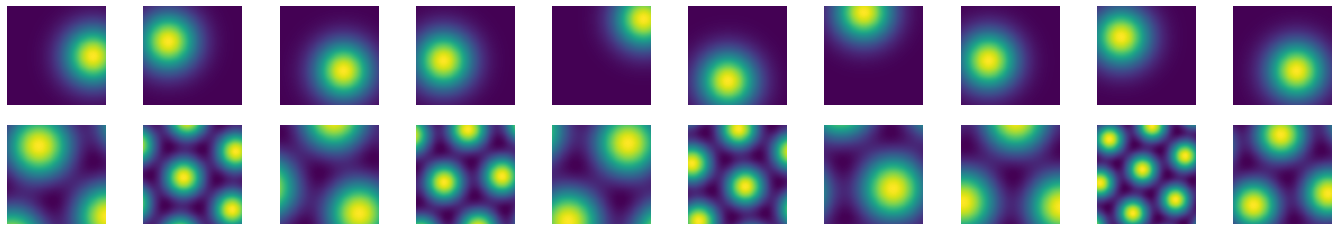

In [69]:
# Show Examples
numExamplesEach = 10
f, ax = plt.subplots(2,numExamplesEach,figsize=(24,4))
for n in range(numExamplesEach):
    ax[0,n].imshow(placeLibrary[np.random.randint(NP)])
    ax[1,n].imshow(gridLibrary[np.random.randint(NG)])
    ax[0,n].axis('off')
    ax[1,n].axis('off')

In [62]:
# Generate a trajectory in the environment
Env = Environment({"scale":boxLength/100}) # (RatInABox uses meters)
Ag = Agent(Env,{'dt':0.1})
for i in range(int(1000/Ag.dt)):
    Ag.update();

# Get trajectory variables
t, pos = np.array(Ag.history["t"]), np.array(Ag.history["pos"])
pos = pos * 100 # convert back to centimeters (to use as index)
posidx = np.floor(pos).astype('int8')

# Return place and grid cell activity along trajectory
placeActivity = placeLibrary[:,posidx[:,0],posidx[:,1]]
gridActivity = gridLibrary[:,posidx[:,0],posidx[:,1]]

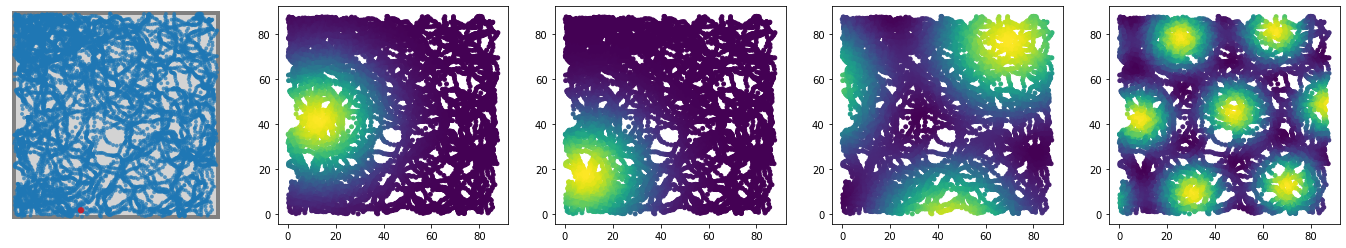

In [70]:
# Plot Trajectory and plot examples of place cell and grid cell activity overlaid on trajectory
numExamplesEach = 2
pexidx = np.random.randint(0,NP,numExamplesEach)
gexidx = np.random.randint(0,NG,numExamplesEach)
f, ax = plt.subplots(1,numExamplesEach*2+1,figsize=(24,4))
Ag.plot_trajectory(ax=ax[0])
for n in range(numExamplesEach):
    ax[n+1].scatter(pos[:,0],pos[:,1],s=15,c=placeActivity[pexidx[n],:])
    ax[n+1+numExamplesEach].scatter(pos[:,0],pos[:,1],s=15,c=gridActivity[gexidx[n],:])
    # ax[0,n].axis('off')
    # ax[1,n].axis('off')

In [71]:
t = time.time()
lPlace,uPlace,covPlace,nvPlace,wPlace,vPlace = ppca(placeActivity.T)
lGrid,uGrid,covGrid,nvGrid,wGrid,vGrid = ppca(gridActivity.T)
print(f"Numpy finished in {time.time() - t} seconds \n-- Likelihood for ppca of place activity = {lPlace} and for grid activity = {lGrid}\n")

Numpy finished in 0.06478214263916016 seconds 
-- Likelihood for ppca of place activity = 1143067.5163257606 and for grid activity = -790546.1787711815



In [147]:
hpcActivity = np.concatenate((placeActivity, gridActivity), axis=0) 

t = time.time()
nEnsemble = 1
nDir = 2
nLeaf = 40
nQuant = 10
randomForest = constructForest(hpcActivity[:,:-1],hpcActivity[:,1:],nEnsemble=nEnsemble,nDir=nDir,nLeaf=nLeaf,nQuant=nQuant)
print(f'Time elapsed numpy: {time.time()-t} seconds')

Time elapsed numpy: 14.558230638504028 seconds


In [ ]:
# now that I have a model, I want to "test it" by finding the likelihood of successor data and shuffled successor data
# so I'll have to write the code that outputs the probability of a datapoint (or set of datapoints) given an input